In [1]:
from scipy.stats import multivariate_normal

import matplotlib.pyplot as plt
import numpy.linalg as nl
import numpy as np

# Gaussian Process Regression

## 2.1 Weight-space View

### 2.1.1 The Standard Linear Model

### Training Setting

In [2]:
# Standard deviation of random noise epsilon: y = f(x) + eps
sigma = 1

# Training data
X = np.concatenate(([[-5,2,5]],[[1,1,1]]), axis=0)
y = np.array([[-6],[1],[4]])

### Prior, Likelihood, and Posterior of $(w_1,w_2)$

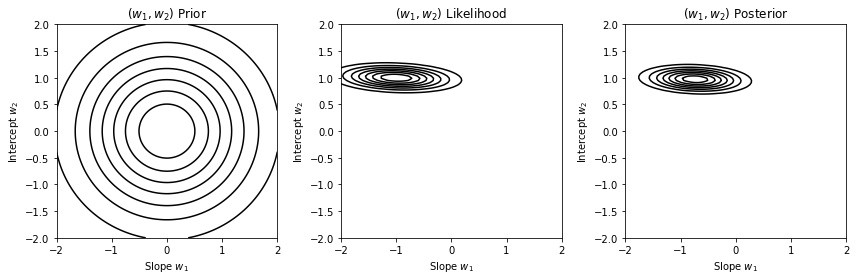

In [3]:
# Prior and Posterior distribution parameters
w_prior = (np.zeros([2]), np.eye(2))

A = (X @ X.T) / sigma ** 2 + nl.inv(w_prior[1])

w_posterior = ((nl.inv(A) @ X @ y).squeeze(), nl.inv(A))

# Plotting
w_1, w_2 = np.meshgrid(np.linspace(-2,2,100), np.linspace(-2,2,100))
ws = np.dstack((w_1, w_2))

prior_rv = multivariate_normal(w_prior[0], w_prior[1])
prior_z = prior_rv.pdf(ws)

def likelihood(X, y, ws, sigma):
    
    n = X.shape[1]
    N = 1 / (2 * np.pi * sigma ** 2) ** (n / 2)
    return np.exp(- np.sum((y.T - ws @ X) ** 2, axis=-1) / (2  * sigma ** 2) ) / N

likelihood_z = likelihood(X, y, ws, 1)

posterior_rv = multivariate_normal(w_posterior[0], w_posterior[1], allow_singular=True)
posterior_z = posterior_rv.pdf(ws)

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.contour(w_1, w_2, prior_z.T, colors='k')
plt.title(r'$(w_1, w_2)$ Prior')
plt.xlabel(r'Slope $w_1$')
plt.ylabel(r'Intercept $w_2$')

plt.subplot(1,3,2)
plt.contour(w_1, w_2, likelihood_z.T, colors='k')
plt.title(r'$(w_1, w_2)$ Likelihood')
plt.xlabel(r'Slope $w_1$')
plt.ylabel(r'Intercept $w_2$')

plt.subplot(1,3,3)
plt.contour(w_1, w_2, posterior_z.T, colors='k')
plt.title(r'$(w_1, w_2)$ Posterior')
plt.xlabel(r'Slope $w_1$')
plt.ylabel(r'Intercept $w_2$')

plt.tight_layout()

plt.show()

### Regression

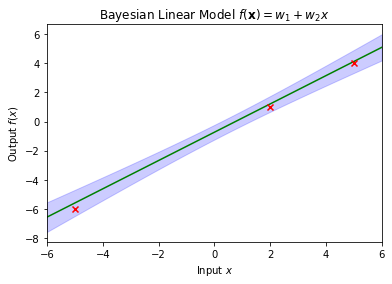

In [4]:
# New data
Xs = np.concatenate((np.linspace(-6,6,100).reshape(1,100), np.ones([1,100])))

# Parameter inference for each instance
y_mean = (Xs.T @ nl.inv(A) @ X @ y).squeeze()
y_std = np.sqrt((Xs.T @ nl.inv(A) @ Xs).diagonal())

# Plotting
plt.figure()

plt.scatter(X[0,:], y, marker='x', color='r', zorder=10)
plt.plot(Xs[0,:], y_mean, color='g')
plt.fill_between(Xs[0,:], y_mean - y_std, y_mean + y_std, alpha=0.2, color='b')
plt.xlim([-6,6])

plt.xlabel(r'Input $x$')
plt.ylabel(r'Output $f(x)$')
plt.title(r'Bayesian Linear Model $f(\mathbf{x}) = w_1 + w_2 x$')

plt.show()

### 2.1.2 Projections of Inputs into Feature Space

### Defining the Projection

In [5]:
# Projection into the space of polynomials of degree <= N
def phi(X, N):
    '''
    X: Array of size (n,1)
    N: Degree of the space of polynomials to be projected into
    '''
    
    return np.concatenate([np.power(X,i) for i in range(N)], axis=1).T

### Training Setting

In [6]:
# Standard deviation of random noise epsilon: y = f(x) + eps
n_data = 10
sigma = 1
N = 5

# Training data
X = np.random.random(size=[n_data,1]) * 10 - 5
y = np.random.random(size=[n_data,1]) * 3 - 1.5

### Prior and Posterior

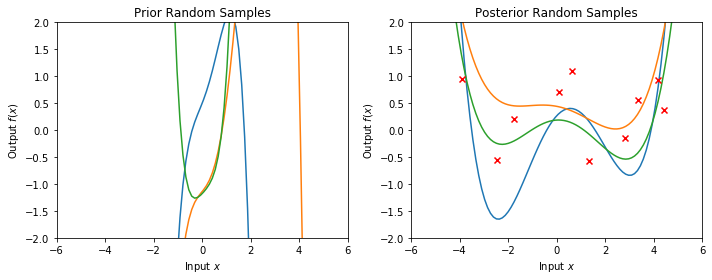

In [7]:
# Prior and Posterior distribution parameters
w_prior = (np.zeros([N]), np.eye(N))

A = (phi(X,N) @ phi(X,N).T) / sigma ** 2 + nl.inv(w_prior[1])

w_posterior = ((nl.inv(A) @ phi(X,N) @ y).squeeze(), nl.inv(A))

prior_rv = multivariate_normal(w_prior[0], w_prior[1], allow_singular=True)
posterior_rv = multivariate_normal(w_posterior[0], w_posterior[1], allow_singular=True)

Xs = np.linspace(-6,6,100).reshape(100,1)
features = phi(Xs,N)

# Plotting
n_samples = 3

prior_samples = features.T @ prior_rv.rvs(n_samples).T
posterior_samples = features.T @ posterior_rv.rvs(n_samples).T

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(Xs.squeeze(), prior_samples)
plt.xlim([-6,6])
plt.ylim([-2,2])

plt.title('Prior Random Samples')
plt.xlabel(r'Input $x$')
plt.ylabel(r'Output $f(x)$')

plt.subplot(1,2,2)
plt.scatter(X.squeeze(), y.squeeze(), marker='x', color='r', zorder=10)
plt.plot(Xs.squeeze(), posterior_samples)
plt.xlim([-6,6])
plt.ylim([-2,2])

plt.title('Posterior Random Samples')
plt.xlabel(r'Input $x$')
plt.ylabel(r'Output $f(x)$')

plt.tight_layout()
plt.show()

### Regression

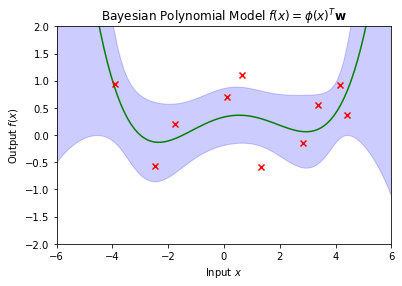

In [8]:
# Parameter inference for each instance
M = phi(Xs, N).T @ w_prior[1] @ phi(X, N)
Q = phi(Xs, N).T @ w_prior[1] @ phi(Xs, N)
K = phi(X, N).T @ w_prior[1] @ phi(X, N)

y_mean = (M @ nl.inv(K + sigma ** 2 * np.eye(n_data)) @ y).squeeze()
y_std = np.sqrt((Q - M @ nl.inv(K + sigma ** 2 * np.eye(n_data)) @ M.T).diagonal())

# Plotting
plt.figure()

plt.scatter(X.squeeze(), y.squeeze(), marker='x', color='r', zorder=10)
plt.plot(Xs.squeeze(), y_mean.squeeze(), color='g')
plt.fill_between(Xs.squeeze(), y_mean.squeeze() - y_std, y_mean + y_std, alpha=0.2, color='b')
plt.xlim([-6,6])
plt.ylim([-2,2])

plt.xlabel(r'Input $x$')
plt.ylabel(r'Output $f(x)$')
plt.title(r'Bayesian Polynomial Model $f(x) = \phi(x)^T \mathbf{w}$')

plt.show()

## 2.2 Function-space View

### 2.2.1 Prediction with Noise-free Observations

### Defining the Covariance Function

In [9]:
def cov(X_1, X_2):
    
    return np.exp(- (X_1 - X_2.T) ** 2 / 2)

### Training Setting

In [10]:
# Standard deviation of random noise epsilon: y = f(x) + eps
n_data = 4
sigma = 0.25

# Training data
X = np.random.random(size=[n_data,1]) * 10 - 5
y = np.random.random(size=[n_data,1]) * 3 - 1.5

### Prior and Posterior

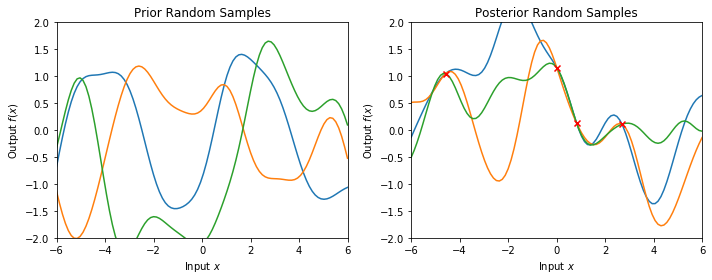

In [11]:
# Prior and Posterior distribution parameters
Xs = np.linspace(-6,6,100).reshape(100,1)

prior = (np.zeros(100), cov(Xs, Xs))
posterior = ((cov(Xs, X) @ nl.inv(cov(X, X)) @ y).squeeze(), cov(Xs, Xs) - cov(Xs, X) @ nl.inv(cov(X, X)) @ cov(X, Xs))

# Plotting
n_samples = 3

prior_rv = multivariate_normal(prior[0], prior[1], allow_singular=True)
prior_samples = prior_rv.rvs(n_samples).T

posterior_rv = multivariate_normal(posterior[0], posterior[1], allow_singular=True)
posterior_samples = posterior_rv.rvs(n_samples).T

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(Xs.squeeze(), prior_samples)
plt.xlim([-6,6])
plt.ylim([-2,2])

plt.title('Prior Random Samples')
plt.xlabel(r'Input $x$')
plt.ylabel(r'Output $f(x)$')

plt.subplot(1,2,2)
plt.scatter(X.squeeze(), y.squeeze(), marker='x', color='r', zorder=10)
plt.plot(Xs.squeeze(), posterior_samples)
plt.xlim([-6,6])
plt.ylim([-2,2])

plt.title('Posterior Random Samples')
plt.xlabel(r'Input $x$')
plt.ylabel(r'Output $f(x)$')

plt.tight_layout()
plt.show()

### Regression

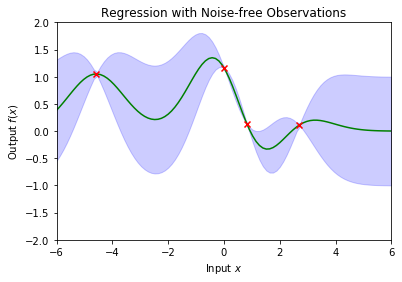

In [12]:
# Parameter inference for each instance
y_mean1 = posterior[0].squeeze()
y_std1 = np.sqrt((posterior[1]).diagonal())

# Plotting
plt.figure()

plt.scatter(X.squeeze(), y.squeeze(), marker='x', color='r', zorder=10)
plt.plot(Xs.squeeze(), y_mean1.squeeze(), color='g')
plt.fill_between(Xs.squeeze(), y_mean1.squeeze() - y_std1, y_mean1 + y_std1, alpha=0.2, color='b')
plt.xlim([-6,6])
plt.ylim([-2,2])

plt.xlabel(r'Input $x$')
plt.ylabel(r'Output $f(x)$')
plt.title(r'Regression with Noise-free Observations')

plt.show()

### 2.2.2 Prediction using Noisy Observations

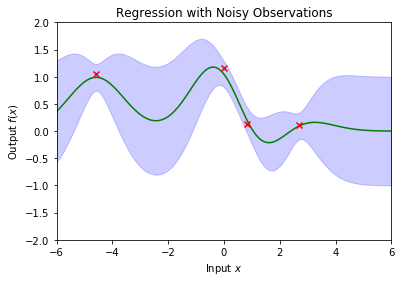

In [13]:
# Prior and Posterior distribution parameters
posterior = ((cov(Xs, X) @ nl.inv(cov(X, X) + sigma ** 2 * np.eye(n_data)) @ y).squeeze(),
             cov(Xs, Xs) - cov(Xs, X) @ nl.inv(cov(X, X) + sigma ** 2 * np.eye(n_data)) @ cov(X, Xs))

# Parameter inference for each instance
y_mean2 = posterior[0].squeeze()
y_std2 = np.sqrt((posterior[1]).diagonal())

# Plotting
plt.figure()

plt.scatter(X.squeeze(), y.squeeze(), marker='x', color='r', zorder=10)
plt.plot(Xs.squeeze(), y_mean2.squeeze(), color='g')
plt.fill_between(Xs.squeeze(), y_mean2.squeeze() - y_std2, y_mean2 + y_std2, alpha=0.2, color='b')
plt.xlim([-6,6])
plt.ylim([-2,2])

plt.xlabel(r'Input $x$')
plt.ylabel(r'Output $f(x)$')
plt.title(r'Regression with Noisy Observations')

plt.show()